In [26]:
import pandas as pd

df = pd.read_excel(r'C:\Users\admin\Desktop\Veri Madencilği\kredi_risk_analizi.xlsx')

In [27]:
features = [
    'Credit Score', 'Annual Income', 'AnnualExpenses', 'Loan Amount',
    'Debt-to-Income Ratio', 'Bankruptcy History', 'Previous Credit Defaults',
    'Payment History', 'Net Worth', 'InterestRate'
]
target_value = 'Credit Approval'

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


# 2. KNN
def select_top_knn(data_subset, features, n_neighbors=10):
    # Extract features
    subset_features = data_subset[features].values

    # Create and fit the NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')  # +1 to account for self-neighbor
    nbrs.fit(subset_features)

    # Compute distances and indices of neighbors
    distances, indices = nbrs.kneighbors(subset_features)

    # Flatten indices and distances to get global top N
    all_indices = indices[:, 1:].flatten()  # Exclude self-neighbor (first column)
    all_distances = distances[:, 1:].flatten()

    # Sort based on distances and take top N
    sorted_indices = np.argsort(all_distances)[:n_neighbors]
    top_indices = all_indices[sorted_indices]

    # Return the top N rows from the dataset
    return data_subset.iloc[top_indices]

In [29]:
data_accepted = df[df[target_value] == 1].sample(n=min(1000, len(df[df[target_value] == 1])), random_state=42)
data_rejected = df[df[target_value] == 0].sample(n=min(1000, len(df[df[target_value] == 0])), random_state=42)

In [30]:
top_accepted = select_top_knn(data_accepted, features, n_neighbors=10).drop('Credit Approval', axis=1)
top_rejected = select_top_knn(data_rejected, features, n_neighbors=10).drop('Credit Approval', axis=1)

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop('Credit Approval', axis=1)
Y = df['Credit Approval']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [32]:
def malatya_centrality(data, dataset):
    graph = [{'index': 0, 'weight': 0, 'links': []} for _ in range(11)]

    current_data = data

    for i in range(len(dataset)):
        compare_by_data = dataset.iloc[i]
        similarities = (current_data == compare_by_data).sum()
        graph[0]['links'].append({'index': dataset.index[i], 'similarities': similarities})
        graph[0]['weight'] += similarities

    for i in range(len(dataset)):
        current_data = dataset.iloc[i]
        graph[i + 1]['index'] = dataset.index[i]

        for j in range(i + 1, len(dataset)):
            compare_by_data = dataset.iloc[j]
            similarities = (current_data == compare_by_data).sum()
            graph[i + 1]['links'].append({'index': dataset.index[j], 'similarities': similarities})
            graph[i + 1]['weight'] += similarities

    for i in range(len(graph) - 1, -1, -1):
        top = 0
        for j in range(i - 1, -1, -1):
            top += [link for link in graph[j]['links'] if link['index'] == graph[i]['index']][0]['similarities']
        graph[i]['weight'] += top

    for i in range(len(graph) - 1, -1, -1):
        centrality = 0
        if i == 0:
            for link in graph[i]['links']:
                centrality += (
                            graph[i]['weight'] / next((node for node in graph if node['index'] == link['index']), None)[
                        'weight'])
                graph[i]['centrality'] = centrality
        for j in range(i - 1, -1, -1):
            for link in graph[j]['links']:
                if link['index'] == graph[i]['index']:
                    centrality += (graph[i]['weight'] / graph[j]['weight'])
                    graph[i]['centrality'] = centrality

    return graph[0]['centrality'], graph

In [33]:
def class_predict(data):
    c1, _ = malatya_centrality(data, top_accepted)
    c2, _ = malatya_centrality(data, top_rejected)

    if c1 > c2:
        return 1
    else:
        return 0

In [34]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_graph(data):
    c1, g1 = malatya_centrality(data, top_accepted)
    c2, g2 = malatya_centrality(data, top_rejected)

    if c1 > c2:
        belong_graph = {'sınıf': 'accept', 'graph': g1}
        non_belong_graph = {'sınıf': 'reject', 'graph': g2}
    else:
        belong_graph = {'sınıf': 'reject', 'graph': g2}
        non_belong_graph = {'sınıf': 'accept', 'graph': g1}

    graphs = [g1, g2]

    for graph in graphs:
        G = nx.Graph()

        node_list = [node for node in graph]

        G.add_nodes_from([node['index'] for node in node_list])

        edges = []

        for node in node_list:
            for link in node['links']:
                if link['similarities'] != 0:
                    edges.append((node['index'], link['index'], link['similarities']))

        G.add_edges_from([(u, v, {"label": label}) for u, v, label in edges])
        node_colors = ['yellow' if node == graph[0]['index'] else 'blue' for node in G.nodes]
        
        if graph == g2:
            node_colors = ['yellow' if node == graph[0]['index'] else 'red' for node in G.nodes]

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800)

        edge_labels = nx.get_edge_attributes(G, "label")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

        plt.show()
    return belong_graph, non_belong_graph


In [35]:
Y_test

987231    0
79954     0
567130    0
500891    0
55399     0
         ..
90245     0
639296    0
311939    0
324459    0
390499    0
Name: Credit Approval, Length: 200000, dtype: int64

In [36]:
X_test.iloc[193]   

Credit Score                  359.000000
Annual Income               63229.000000
AnnualExpenses              32186.000000
Loan Amount                 17614.000000
Debt-to-Income Ratio            0.798218
Bankruptcy History              1.000000
Previous Credit Defaults        0.000000
Payment History                22.000000
Net Worth                   38017.000000
InterestRate                    0.087590
Name: 727932, dtype: float64

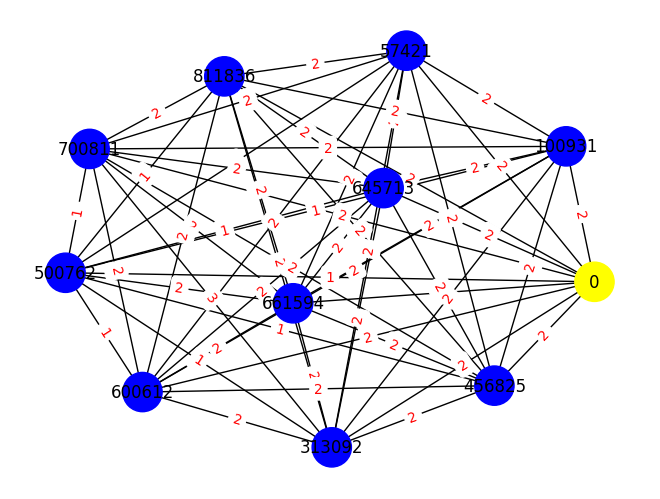

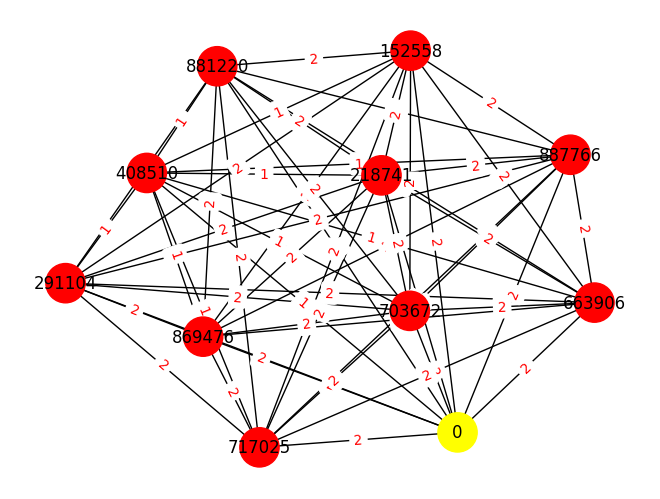

In [37]:
selected_graph, non_selected_graph= plot_graph(X_test.iloc[6])

In [38]:
centrality_table = [x['centrality'] for x in selected_graph['graph']]
index_table = [x['index'] for x in selected_graph['graph']]
pd.DataFrame({'centrality': centrality_table}, index=index_table)

,centrality
0,10.900000
408510,0.526316
869476,2.900000
291104,3.900000
881220,4.900000
703672,5.900000
887766,6.900000
152558,7.900000
663906,8.900000
218741,9.900000


In [39]:
centrality_table = [x['centrality'] for x in non_selected_graph['graph']]
index_table = [x['index'] for x in selected_graph['graph']]
pd.DataFrame({'centrality': centrality_table}, index=index_table)

,centrality
0,10.577273
408510,1.052632
869476,1.950000
291104,2.950000
881220,2.286842
703672,5.677273
887766,7.028708
152558,7.627273
663906,8.627273
218741,10.133971


In [40]:
selected_graph['sınıf']

'reject'

In [41]:
y_pred = pd.DataFrame(
    {'class': [class_predict(data_point) for data_point in X_test.head(200).itertuples(index=False)]})

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_test.head(200), y_pred)
precision = precision_score(Y_test.head(200), y_pred)
recall = recall_score(Y_test.head(200), y_pred)
f1 = f1_score(Y_test.head(200), y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.645
Precision: 0.28
Recall: 0.12
F1-Score: 0.16


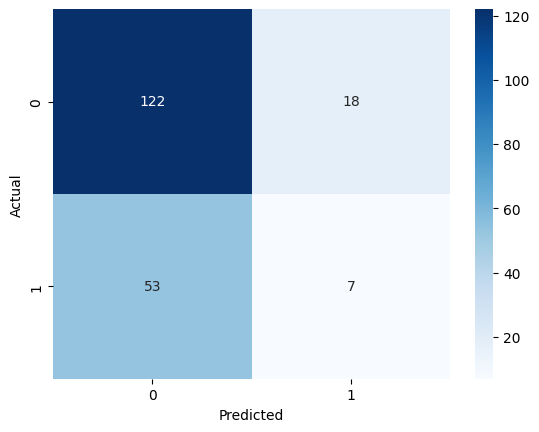

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test.head(200), y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()